<a href="https://colab.research.google.com/github/hhhzs/Chicago-Crime-Analysis/blob/main/CS483_Final_Project_Crime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and set up(ADD MORE HERE IF NEEDED )

In [ ]:
%%capture
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!pip install pyodata
!pip install dtreeviz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Let's import the libraries we will need
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import itertools
from collections import defaultdict
#####################################################
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress
from pandas import ExcelWriter
from pandas import ExcelFile

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Data cleaning

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

from random import randint

#REad LA crime data file "Crime Data from 2020 to Present"
df_LA = pd.read_csv("https://data.lacity.org/api/views/2nrs-mtv8/rows.csv")
#drop the null attributes in cleaning
#df_LA = df_LA.dropna()
features = ['LAT', 'LON', 'TIME OCC']
targetFeature = ['Crm Cd Desc']
df_LA['Date'] = pd.to_datetime(df_LA['DATE OCC'])


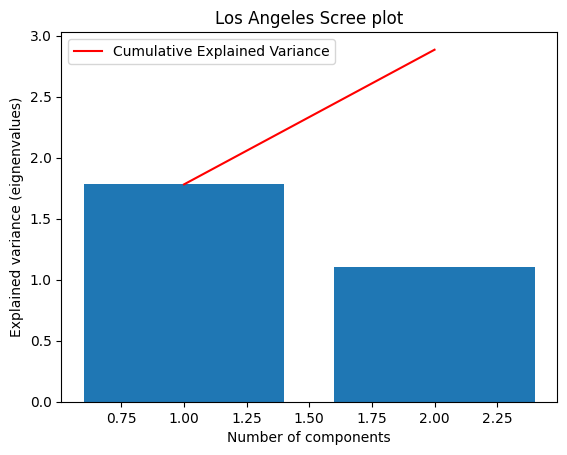

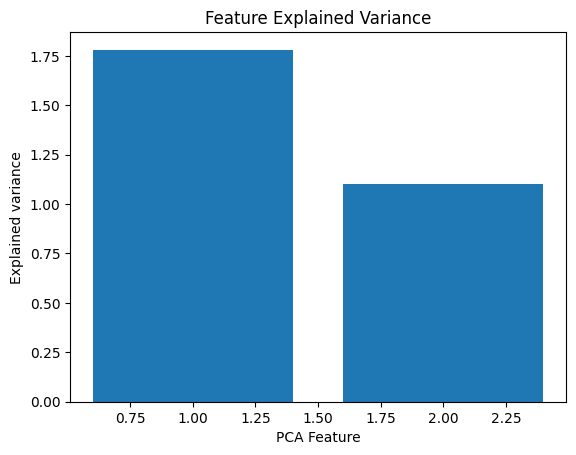

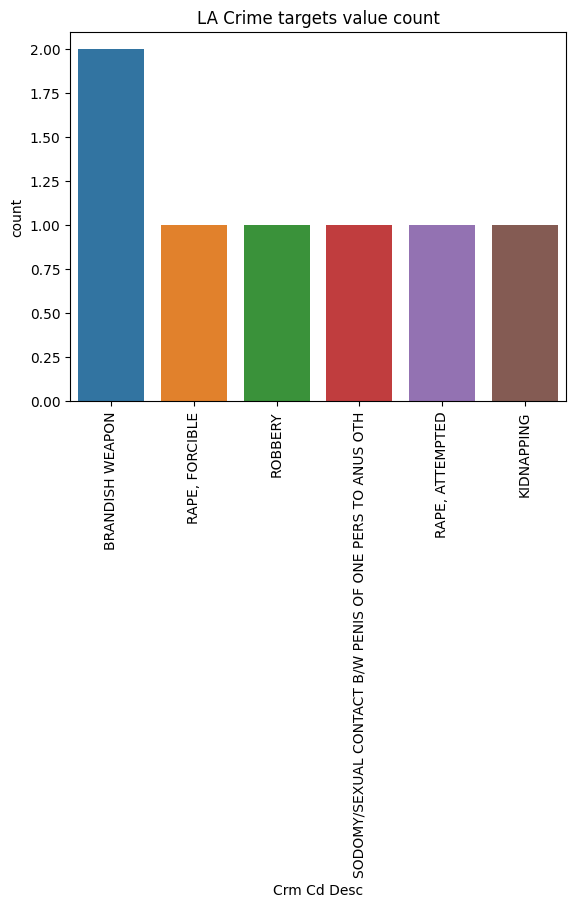

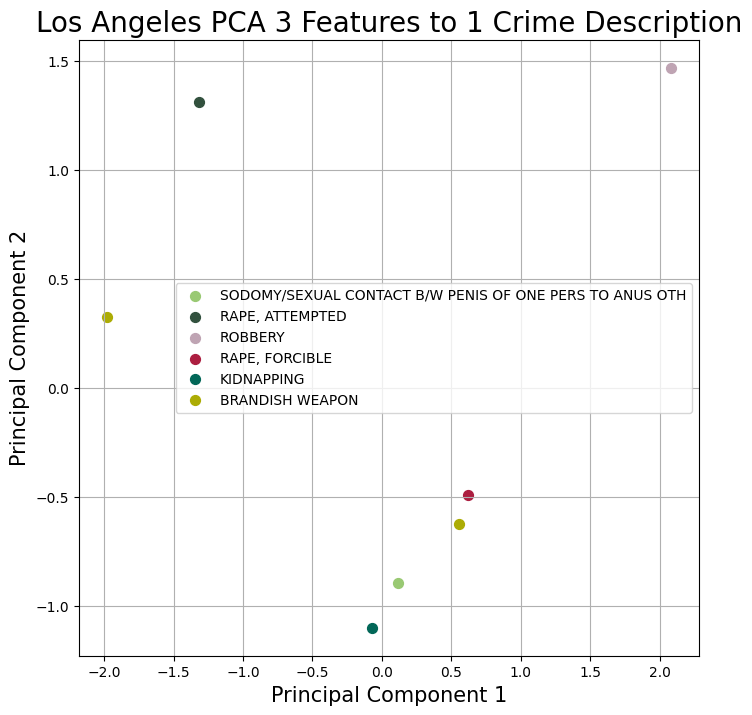

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

x = df_LA.loc[:, features].values
y = df_LA.loc[:,targetFeature].values
x = StandardScaler().fit_transform(x)

targets = df_LA.loc[:,targetFeature].values
targets = [j for sub in targets for j in sub]
targets = list(set(targets))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Los Angeles Scree plot')
 
plt.show()

plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_LA[targetFeature].reset_index(drop=True)], axis = 1)
sns.countplot(
    x=targetFeature[0], 
    data=finalDf)
plt.title('LA Crime targets value count')
plt.xticks(rotation=90)
plt.show()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Los Angeles PCA 3 Features to 1 Crime Description', fontsize = 20)
#Plot the PCA
# targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# colors = ['r', 'g', 'b']
colors = []
for i in range(len(targets)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[targetFeature[0]] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
df_LA.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

Data mining implementation

In [ ]:
#Now we can do some data mining techniques we learned form class to analyze the data

<ipython-input-7-aaa8339b728f>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))


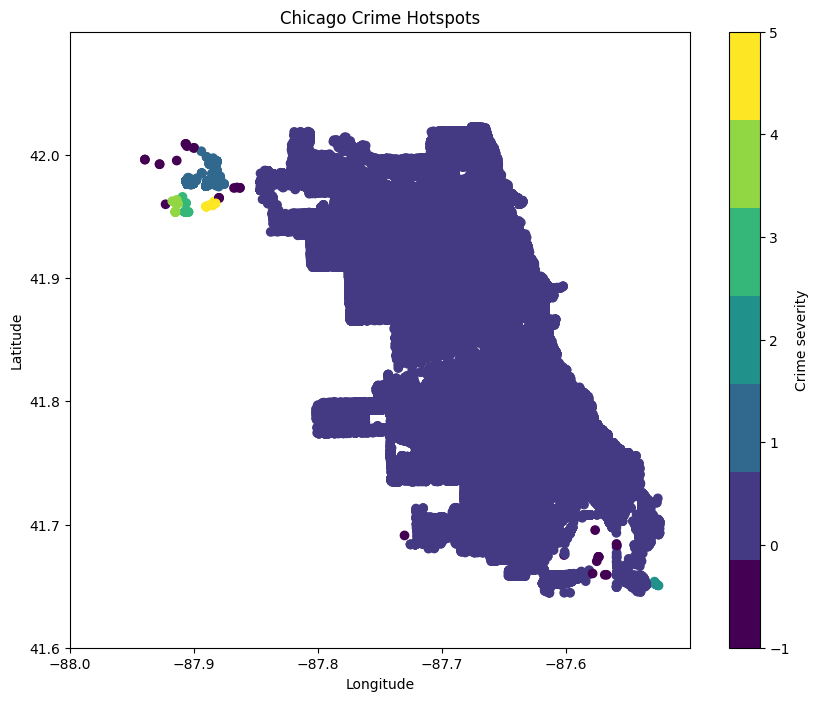

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# read the CSV file into a pandas DataFrame
#df = pd.read_csv('final.csv') #for final.csv
#Crimes - 2022 - https://data.cityofchicago.org/api/views/9hwr-2zxp/rows.csv
#Crimes - 2023-present - https://data.cityofchicago.org/api/views/xguy-4ndq/rows.csv
#Crimes - 2021 - https://data.cityofchicago.org/api/views/dwme-t96c/rows.csv
#Crimes - 2020 - https://data.cityofchicago.org/api/views/qzdf-xmn8/rows.csv


df = pd.read_csv("https://data.cityofchicago.org/api/views/9hwr-2zxp/rows.csv")
# drop any rows that have missing values
df = df.dropna()
# extract the latitude and longitude information from the DataFrame
#X = df[['LATITUDE', 'LONGITUDE']].values # for final.csv
X = df[['Latitude', 'Longitude']].values 
# scale the latitude and longitude values using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply DBSCAN to identify crime hotspots
dbscan = DBSCAN(eps=0.1, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

# create a custom colormap for the clusters
cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))

# plot the crime hotspots using a   
fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(X[:, 1], X[:, 0], c=labels, cmap=cmap)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Chicago Crime Hotspots')
ax.set_xlim(-88.0, -87.5)
ax.set_ylim(41.6, 42.1)
ax.set_xticks(np.arange(-88.0, -87.5, 0.1))
ax.set_yticks(np.arange(41.6, 42.1, 0.1))

# add colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Crime severity')
plt.show()


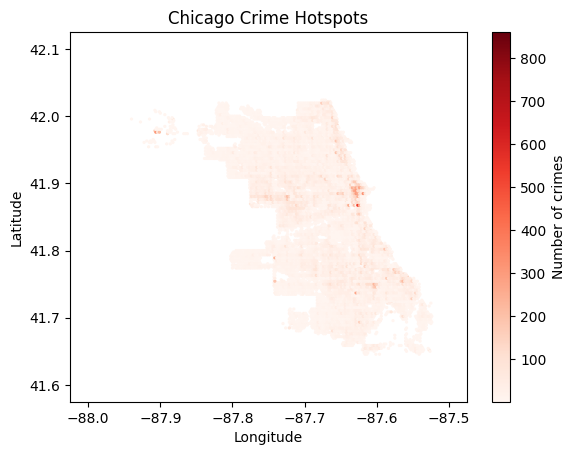

In [ ]:
# extract the latitude and longitude information from the DataFrame

# X = df_clean[['LATITUDE', 'LONGITUDE']].values - Original
#X = df[['LATITUDE', 'LONGITUDE']].values #for final.csv
X = df[['Latitude', 'Longitude']].values

# create a hexbin plot of the crime hotspots
plt.hexbin(x=X[:, 1], y=X[:, 0], gridsize=200, cmap='Reds', mincnt=1, extent=[-88.0, -87.5, 41.6, 42.1])
plt.title('Chicago Crime Hotspots')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# add a colorbar to the plot
cb = plt.colorbar()
cb.set_label('Number of crimes')

plt.show()


In [ ]:
# A
crime_categories = {
    'ARSON': 'property',
    'ASSAULT': 'violent',
    'BATTERY': 'violent',
    'BURGLARY': 'property',
    'CONCEALED CARRY LICENSE VIOLATION': 'weapon',
    'CRIMINAL DAMAGE': 'property',
    'CRIMINAL TRESPASS': 'property',
    'DECEPTIVE PRACTICE': 'fraud',
    'DOMESTIC VIOLENCE': 'violent',
    'GAMBLING': 'vice',
    'HOMICIDE': 'violent',
    'HUMAN TRAFFICKING': 'vice',
    'INTERFERENCE WITH PUBLIC OFFICER': 'weapon',
    'INTIMIDATION': 'violent',
    'KIDNAPPING': 'violent',
    'LIQUOR LAW VIOLATION': 'vice',
    'MOTOR VEHICLE THEFT': 'property',
    'NARCOTICS': 'drug',
    'NON-CRIMINAL': 'other',
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 'other',
    'OBSCENITY': 'vice',
    'OFFENSE INVOLVING CHILDREN': 'violent',
    'OTHER NARCOTIC VIOLATION': 'drug',
    'OTHER OFFENSE': 'other',
    'PROSTITUTION': 'vice',
    'PUBLIC INDECENCY': 'vice',
    'PUBLIC PEACE VIOLATION': 'weapon',
    'ROBBERY': 'violent',
    'SEX OFFENSE': 'violent',
    'STALKING': 'violent',
    'THEFT': 'property',
    'WEAPONS VIOLATION': 'weapon'
}

# create a new column in the DataFrame that maps primary descriptions to crime categories
#df['CRIME CATEGORY'] = df['PRIMARY DESCRIPTION'].map(crime_categories) #for final.csv

df['CRIME CATEGORY'] = df['Primary Type'].map(crime_categories) #for final.csv

# drop any rows that have missing values
df = df.dropna()

# print the number of crimes in each category
print(df['CRIME CATEGORY'].value_counts())


property    113432
violent      74726
other        14232
fraud        14191
weapon        9966
drug          3972
vice           554
Name: CRIME CATEGORY, dtype: int64


Machine learning model implementation

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'CRIME CATEGORY'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 231073 entries, 0 to 238176
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    231073 non-null  int64  
 1   Case Number           231073 non-null  object 
 2   Date                  231073 non-null  object 
 3   Block                 231073 non-null  object 
 4   IUCR                  231073 non-null  object 
 5   Primary Type          231073 non-null  object 
 6   Description           231073 non-null  object 
 7   Location Description  231073 non-null  object 
 8   Arrest          

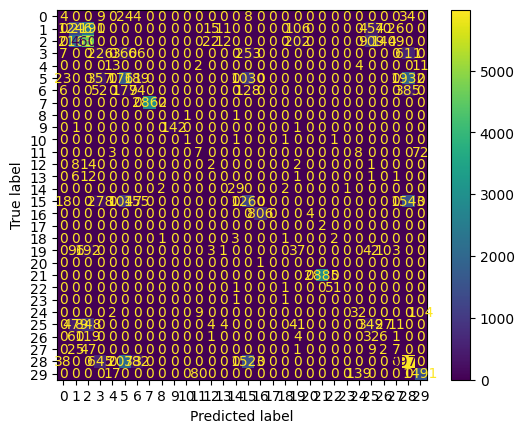

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import graphviz

print(df.columns)

print(df.info())


# Select the features and target variable
X = df.drop([ "Case Number", "Date", "Block", "IUCR", "Primary Type", "Description", "Location Description", "Arrest", "Domestic", "FBI Code", "Location"], axis=1)
print(X)
y = df["Primary Type"]

# Convert categorical variables to numerical variables using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()



Accuracy: 0.24290814670561506


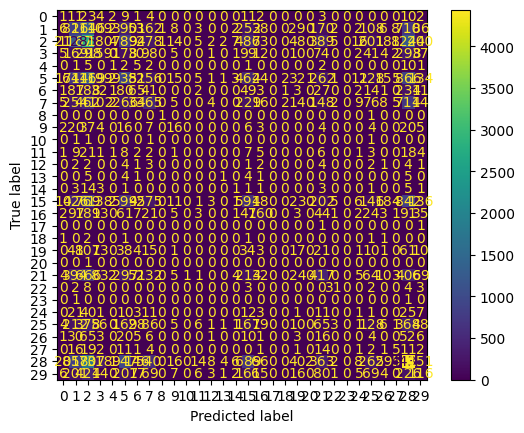

In [ ]:
from sklearn import preprocessing, tree

# Load and read crime data
crime_df = df.drop(columns=['Year','ID','Case Number','District','Community Area', 'Block', "Description","Location Description", "Arrest", 'FBI Code', 'IUCR', 'Domestic','Updated On', 'Location', 'CRIME CATEGORY'])

# print(crime_df.head(10))

# Convert the date column to a datetime object
crime_df['Date'] = pd.to_datetime(crime_df['Date'])
crime_df['TOD'] = crime_df['Date'].dt.time # time of day

# Partition the dataset by year
crime_df['YEAR'] = crime_df['Date'].dt.year
crime_dfD = crime_df
crime_df = crime_df.drop(columns=['Date', 'Date','TOD'])

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(crime_df['Primary Type'].values)
crime_df['target'] = label_encoder.transform(crime_df['Primary Type'])
crime_df = crime_df.drop(columns=["Primary Type"])
# Create a function to prepare the dataset for model training and testing
def prepare_data(crime_df, target_col, test_size=0.2, random_state=42):
    X = crime_df.drop(target_col, axis=1)
    y = crime_df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Prepare the dataset for training and testing
X_train, X_test, y_train, y_test = prepare_data(crime_df, 'target')

# Initialize the decision tree classifier
clf = DecisionTreeClassifier()

# Fit the model to the training data
clf.fit(X_train.values, y_train.values)

# Predict the crime types for the test data
y_pred = clf.predict(X_test.values)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#Chicago Random Forest with column transformer
# load data
df_Chic = pd.read_csv('https://data.cityofchicago.org/api/views/9hwr-2zxp/rows.csv')

# select columns for one-hot encoding and numeric columns for imputation
cat_cols = ['Primary Type', 'Description', 'Location Description']
num_cols = ['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude']

# define column transformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_Chic.drop('Arrest', axis=1), df_Chic['Arrest'], test_size=0.2, random_state=42)

# preprocess data and fit random forest classifier
x_trainbefore = X_train
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rfc.predict(X_test)
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehotencoder']
cat_feature_names = cat_encoder.get_feature_names(cat_cols)

# concatenate the names of all the features
feature_names = num_feature_names + cat_feature_names.tolist()
#3 trees from Decision Forest
for i in range(3):
    tree = rfc.estimators_[i]
    dot_data = export_graphviz(tree, out_file=None, max_depth=2,
                               feature_names=feature_names,
                               class_names=['No Arrest', 'Arrest'],
                               filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph = graphviz.Source(dot_data)
    file_ext = 'png'
    temp_img = f'temp_file{i}'
    graph.render(temp_img,format=file_ext, view=False)
# evaluate model
score = rfc.score(X_test, y_test)
print('Accuracy:', score)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

AttributeError: ignored

Text(0, 0.5, 'Accuracy Score')

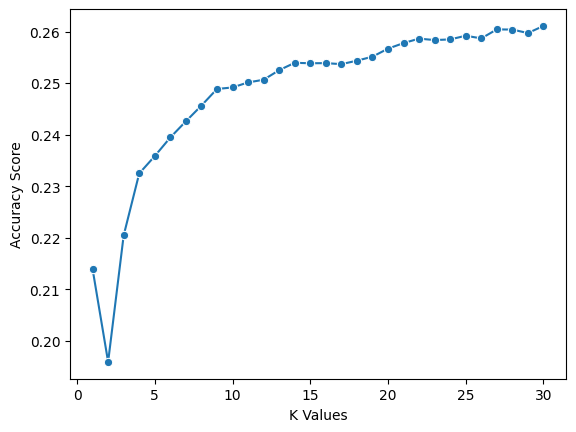

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [ ]:
#3 trees from Decision Forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    file_ext = 'png'
    temp_img = f'temp_file{i}'
    graph.render(temp_img,format=file_ext, view=False)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# param_dist = {'n_estimators': [randint(50,500)],
#               'max_depth': [randint(1,20)]}

# # Create a random forest classifier
# rf = RandomForestClassifier()

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=5, 
#                                  cv=5)

# # Fit the random search object to the data
# rand_search.fit(X_train, y_train)
# best_rf = rand_search.best_estimator_


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.


In [ ]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='micro')
recall = recall_score(y_test, y_pred,average='micro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.2569456465293405
Precision: 0.2569456465293405
Recall: 0.2569456465293405


In [ ]:
# Predict the crime types for a given street or neighborhood
# can be modified for different neighborhoods for prediction in crime
new_data = pd.DataFrame({
    'Beat': [123],
    'Ward': [5],
    'X Coordinate': [123456],
    'Y Coordinate': [654321],
    'Latitude': [41.1234],
    'Longitude': [-87.4321],
    'YEAR': [2023] # year to predict for
})

y_pred = clf.predict(new_data)

print(y_pred) # array of predicted crime types


['THEFT']


In [ ]:


viz = dtreeviz.model(clf,
         X_train,
         y_train,
         target_name='toy',
         feature_names=X_train.columns,
         class_names=list(label_encoder.classes_)
         )
v = viz.view()     # render as SVG into internal object 
v.show() 

AttributeError: ignored

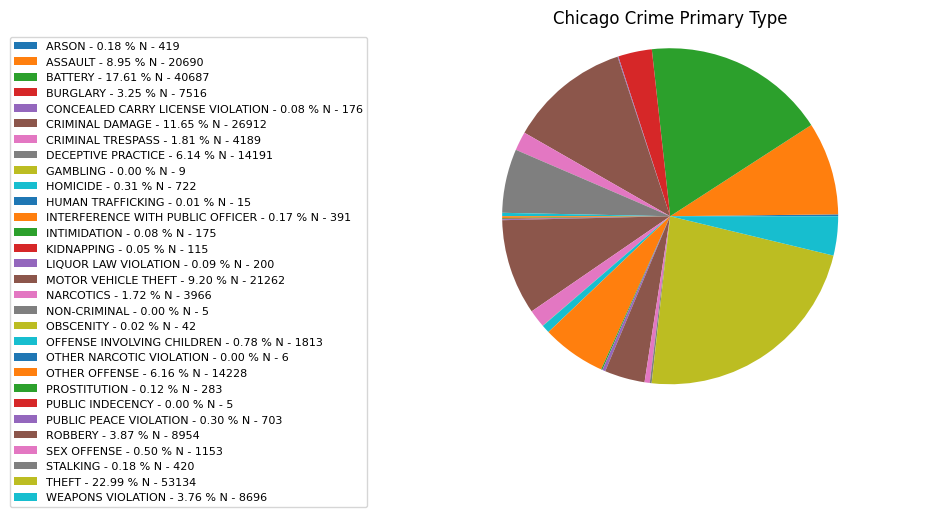

In [ ]:
import matplotlib.pyplot as plt
import pandas
#plot = df.groupby('Primary Type').size().plot(kind='pie', figsize=(5, 5),autopct='%.2f',startangle=45)
#plot


# Calculate percentages points
percent = 100.*df.groupby('Primary Type').size()/df.groupby('Primary Type').size().sum()
percent['count'] = df.groupby('Primary Type').size()
# Write label in the format "Manufacturer - Percentage %"
labels = ['{0} - {1:1.2f} % N - {2:}'.format(i,j,df.groupby('Primary Type').size()[i]) for i,j in zip(np.sort(df['Primary Type'].unique()), percent)]

ax = df.groupby('Primary Type').size().plot(kind='pie', labels=None) # the pie plot
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
ax.yaxis.label.set_visible(False) # disable y-axis label
# add the legend
ax.legend(labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.title("Chicago Crime Primary Type")
plt.show()


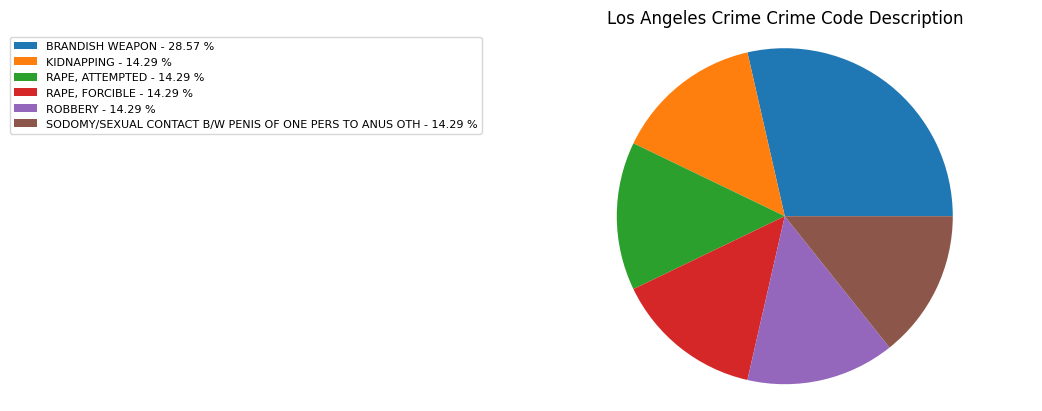

In [ ]:
import matplotlib.pyplot as plt
#plot = df.groupby('Primary Type').size().plot(kind='pie', figsize=(5, 5),autopct='%.2f',startangle=45)
#plot


# Calculate percentages points
percent = 100.*df_LA.groupby('Crm Cd Desc').size()/df_LA.groupby('Crm Cd Desc').size().sum()

# Write label in the format "Manufacturer - Percentage %"
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(np.sort(df_LA['Crm Cd Desc'].unique()), percent)]

ax = df_LA.groupby('Crm Cd Desc').size().plot(kind='pie', labels=None) # the pie plot
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
ax.yaxis.label.set_visible(False) # disable y-axis label
# add the legend
ax.legend(labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.title("Los Angeles Crime Crime Code Description")
plt.show()


Text(0.5, 1.0, 'Time of Day Chicago for Primary Types')

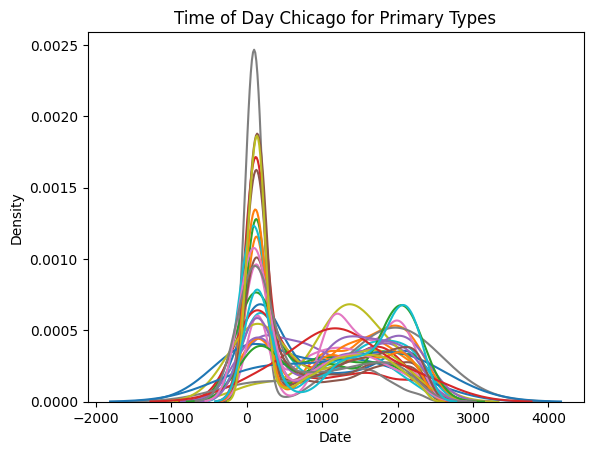

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
#Chicago

## This block of code is copied from Student240's answer:
import random 





###split the data into groups based on types
g = crime_dfD.groupby('Primary Type')

## From here things change as I make use of the seaborn library

fig, ax = plt.subplots()
for key in g.groups.keys():
  ax = sns.kdeplot(data=g.get_group(key)['Date'].dt.strftime("%-H%-M").astype(int), label='Time of Day', ax=ax,legend=True)
  #ax.set_xtitle('Count')
  #ax.set_ytitle('Density')
#xfmt = mdates.DateFormatter('%m-%d')
ax.get_xaxis().set_visible(True)
ax.set_title("Time of Day Chicago for Primary Types")

In [ ]:
df_LA.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

<ipython-input-116-2a1b452ab5e2>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data=g.get_group(key)['TIME OCC'], label='Time of Day', ax=ax,legend=True)
<ipython-input-116-2a1b452ab5e2>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data=g.get_group(key)['TIME OCC'], label='Time of Day', ax=ax,legend=True)


Text(0.5, 1.0, 'Time of Day Los Angeles for Crime Code Description')

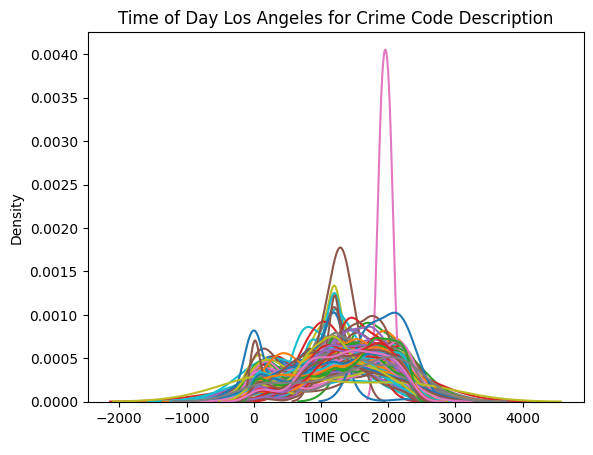

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


import random 



#Los Angeles

###split the data into groups based on types
g = df_LA.groupby('Crm Cd Desc')

## From here things change as I make use of the seaborn library

fig, ax = plt.subplots()
for key in g.groups.keys():
  ax = sns.kdeplot(data=g.get_group(key)['TIME OCC'], label='Time of Day', ax=ax,legend=True)
  #ax.set_xtitle('Count')
  #ax.set_ytitle('Density')
#xfmt = mdates.DateFormatter('%m-%d')
ax.get_xaxis().set_visible(True)
ax.set_title("Time of Day Los Angeles for Crime Code Description")

In [ ]:
for key in g.groups.keys():
  print(g.get_group(key)['TIME OCC'])#.dt.strftime("%-H%-M"))

13        1638
914       1104
1063      1720
1166        45
1213       820
          ... 
706214    1052
706539    1430
707042    1920
707557     328
708017     940
Name: TIME OCC, Length: 1959, dtype: int64
3702        15
4297      2049
5468      1625
5907      2000
5929      2145
          ... 
697664    1615
704816    1130
705335    1515
706800    1750
706973    1750
Name: TIME OCC, Length: 897, dtype: int64
24         700
27        2000
42        2040
43         920
61        1200
          ... 
708038    1735
708039     600
708042    1930
708081    1000
708082    1630
Name: TIME OCC, Length: 40642, dtype: int64
245       2140
285       1555
331       2100
494       1845
513       1445
          ... 
707559    1522
707592     110
707644    1000
707842    2235
708008    2050
Name: TIME OCC, Length: 3740, dtype: int64
0         2230
1          330
28        2000
37        1255
39        1000
          ... 
708031    1930
708034    1540
708054    1745
708065     910
708066    1735
Nam

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://data.cityofchicago.org/api/views/9hwr-2zxp/rows.csv")
# drop any rows that have missing values
df = df.dropna()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

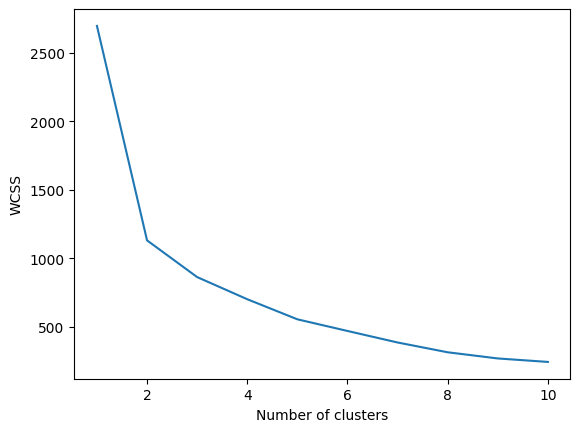

In [ ]:
lat_long = df[['Latitude', 'Longitude']]

wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(lat_long) 
    wcss.append(kmeans.inertia_)

kmeans.fit(lat_long) 
plt.plot(range(1, 11), wcss) 
plt.xlabel('Number of clusters') 
y_kmeans = kmeans.fit_predict(lat_long)
plt.ylabel('WCSS') 
plt.show()

In [ ]:
cluster_to_pred = 3
crime_type = 'THEFT'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-31-3cfe1ecd7ae2>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g = X[df['Cluster'] == label]


<Figure size 2000x1000 with 0 Axes>

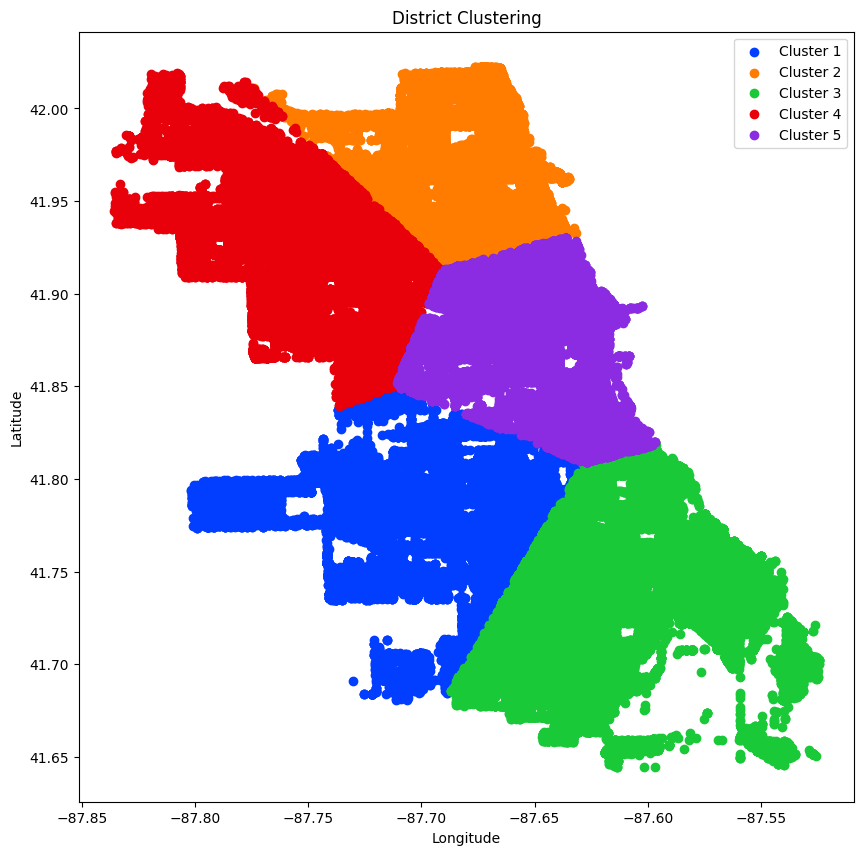

The possibility of THEFT in each cluster 
 Cluster
0    17.851388
1    32.211885
2    16.190062
3    17.709270
4    33.364314
Name: Primary Type, dtype: float64


Text(0, 0.5, '%')

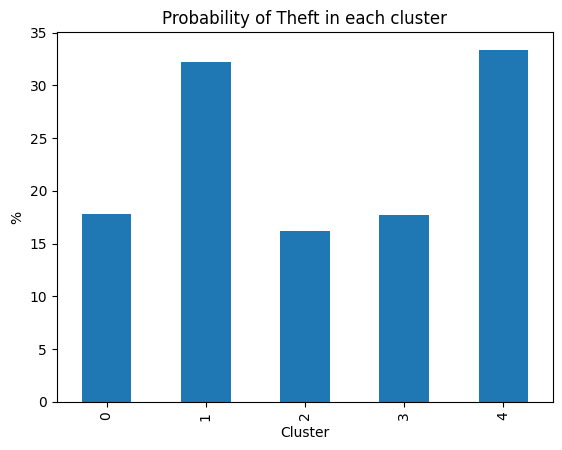

In [ ]:
cluster_num = 5

kmeans = KMeans(n_clusters=cluster_num, random_state=0).fit(lat_long)

df['Cluster'] = kmeans.labels_
cluster_counts = df.groupby('Cluster')['Primary Type'].apply(lambda x: (x == crime_type).sum())
total_counts = df.groupby('Cluster')['Primary Type'].count()
theft_likelihood = (cluster_counts/total_counts) * 100

X = lat_long
# Calculate the interquartile range (IQR) of the data
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Remove all data points that are outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
X = X[~((X < (Q1 - 1.5*IQR)) | (X > (Q3 + 1.5*IQR))).any(axis=1)]

# Cluster the data points using KMeans
kmeans = KMeans(n_clusters=cluster_num, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Plot the districts with different colors for each cluster
plt.figure(figsize=(20, 10))
graph_colors = sns.color_palette('bright', 10)

# Plot the districts with different colors for each cluster and label each data point with its district number
plt.figure(figsize=(10, 10))
for label in range(cluster_num):
    g = X[df['Cluster'] == label]
    plt.scatter(g['Longitude'], g['Latitude'], label=f"Cluster {label+1}", color=graph_colors[label])
        
        
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('District Clustering')
plt.legend()
plt.show()

print("The possibility of THEFT in each cluster \n", theft_likelihood)
plot_poss = pd.DataFrame({'Theft': theft_likelihood})
plot_poss['Theft'].plot(kind="bar")
plt.title("Probability of Theft in each cluster")
plt.ylabel("%")

more clusters = lower accuracy and higher precision

less clusters = higher precision and lower accuracy


In [ ]:
# extract year and month from date
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %I:%M:%S %p")

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

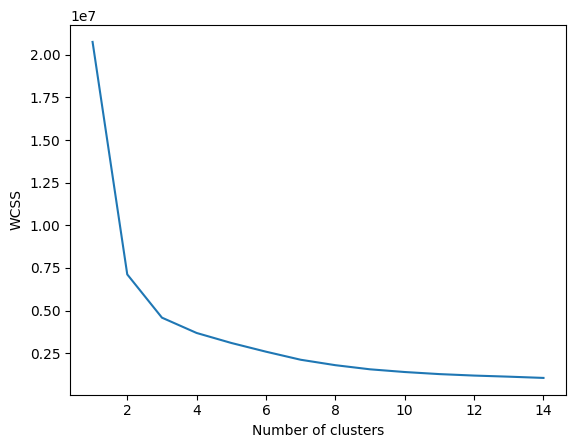

In [ ]:
X = df[['Year', 'Month', 'Day', 'Latitude', 'Longitude']]
wcss = [] 
for i in range(1, 15): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)

kmeans.fit(X) 
plt.plot(range(1, 15), wcss) 
plt.xlabel('Number of clusters') 
y_kmeans = kmeans.fit_predict(X)
plt.ylabel('WCSS') 
plt.show()

In [ ]:
n_c = 6

X = df[['Year', 'Month', 'Day', 'Latitude', 'Longitude']]

# Remove missing values
X = X.dropna()

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=n_c, random_state=42)
kmeans.fit(X_std)

# Get the cluster labels for each data point
labels = kmeans.predict(X_std)

df['Cluster'] = labels

cluster_data = df[df['Cluster'] == cluster_to_pred]

cluster_data['Target'] = np.where(cluster_data['Primary Type'] == crime_type, 1, 0)

X1 = cluster_data[['Year', 'Month', 'Day', 'Latitude', 'Longitude']]
y = cluster_data['Target']

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)

# Fit a logistic regression model to the training data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Evaluate the performance of the model on the test data
y_pred = logreg.predict(X_test)

print("{} in cluster {}".format(crime_type, cluster_to_pred))
print('Accuracy score:', accuracy_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


THEFT in cluster 3
Accuracy score: 0.7966552641581148
Confusion matrix:
 [[8384    0]
 [2140    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      8384
           1       0.00      0.00      0.00      2140

    accuracy                           0.80     10524
   macro avg       0.40      0.50      0.44     10524
weighted avg       0.63      0.80      0.71     10524



<ipython-input-24-53d356be1fac>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Target'] = np.where(cluster_data['Primary Type'] == crime_type, 1, 0)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [ ]:
# Predicting Victim sex based on Crime types on LA data using LightGBM(Decision tree)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv("Los_crime.csv")

# Filter relevant columns
data = data[["Vict Sex", "Crm Cd Desc", "Weapon Used Cd", "Weapon Desc", "Vict Descent"]]

# Remove observations with "H" and "X"
data = data[data["Vict Sex"].isin(["M", "F"])]

# Handle missing or invalid data (you can use different techniques)
data.dropna(inplace=True)

# Encode categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data[["Crm Cd Desc", "Weapon Used Cd", "Weapon Desc", "Vict Descent"]]).toarray()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(encoded_features, data["Vict Sex"], test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train model using LightGBM
model = LGBMClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Evaluate model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))


In [ ]:
# Predicting if arrested by the location, crime type with random forest classifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# load data
df = pd.read_csv('Chicago_crime.csv')

# select columns for one-hot encoding and numeric columns for imputation
cat_cols = ['Primary Type', 'Description', 'Location Description']
num_cols = ['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude']

# define column transformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Arrest', axis=1), df['Arrest'], test_size=0.2, random_state=42)

# preprocess data and fit random forest classifier
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# make predictions and evaluate model
y_pred = rfc.predict(X_test)
print('Accuracy:', rfc.score(X_test, y_test))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
